### Import libaries

In [1]:
import pandas as pd
import torch

from typing import Dict, List, Tuple

from gflownet import GFNTask, LogScalar, ObjectProperties
from gflownet.online_trainer import StandardOnlineTrainer
from torch import Tensor
from rdkit.Chem.rdchem import Mol as RDMol

from gflownet.config import init_empty, Config
from gflownet.envs.mol_building_env import MolBuildingEnvContext
from rdkit.Chem.Draw import MolsToGridImage


from rdkit import Chem,DataStructs

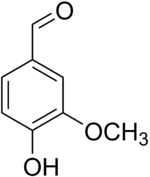

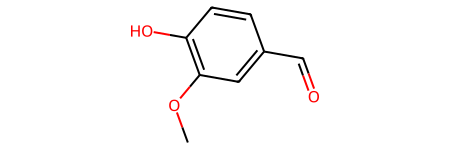

In [2]:
vanillin = "[H]C(=O)C1=CC(OC)=C(O)C=C1"
mol = Chem.MolFromSmiles(vanillin)
mol

In [3]:
import numpy as np

In [4]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
dev = torch.device('cpu')

### Load dataset

The dataset below contains different molecules and their coresponding olfactory notes. The data should be used to formulate a fitting reward funtion. It is however not used in this notebook yet. 

In [6]:
#df = pd.read_csv("data.csv")
#df.head()

### Define task

Create a model to generatate molecules with a high fluor content. This is a simple objective to test the libary. Calculating $R(T)$ for our olfactory notes is the real challenge. 

The first step is to write a function counting the amount of fluor atoms in a molecule.

In [6]:
from pom_models.functions import fragance_propabilities_from_smiles

vanilinprob = fragance_propabilities_from_smiles(vanillin)[0]#"COC1=C(C=CC(=C1)C=O)O"))

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (d:\Dokumenter\Skole\Prosjektoppgave\prosjektKopi\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [7]:
vanilinprob

array([0.04575705, 0.04282942, 0.05341665, 0.2864027 , 0.03292181,
       0.20288868, 0.36172262, 0.02111002, 0.04237434, 0.317042  ,
       0.4279455 , 0.03573177, 0.03719727, 0.02371974, 0.13851587,
       0.32038513, 0.02894411, 0.01613994, 0.32080555, 0.09608915,
       0.03982432, 0.08091616, 0.27430353, 0.02159856, 0.07350694,
       0.03478025, 0.05178089, 0.25843382, 0.11839368, 0.21073033,
       0.06080894, 0.06195458, 0.34229103, 0.06232229, 0.146159  ,
       0.16066003, 0.01784374, 0.05046922, 0.09188339, 0.07404198,
       0.28687143, 0.3541201 , 0.00835921, 0.10641307, 0.16819969,
       0.1959213 , 0.18295589, 0.06957998, 0.05369797, 0.06176599,
       0.44382554, 0.099797  , 0.04375359, 0.34240264, 0.04317854,
       0.04487146, 0.06809819, 0.1567298 , 0.02871715, 0.03830222,
       0.12342923, 0.30967513, 0.28897983, 0.04847127, 0.24057145,
       0.11724697, 0.05389829, 0.05945813, 0.02251486, 0.02622348,
       0.09840047, 0.01832962, 0.05089313, 0.19233458, 0.02440

In [10]:
vanilin_mask = list(map(lambda x:  1 if x>0.45 else  0, vanilinprob))
vanilin_mask.count(1)

5

In [11]:
def reward_function_model(mol):
    value = 0
    smiles = Chem.MolToSmiles(mol)
    atoms=mol.GetAtoms()

    if len(atoms) <= 1:
        return 1
    #reward_array = np.array([[ 10  if i%2==0  else 0 for i in range(138)]])
    reward_array = np.array(vanilin_mask) * 10
    probabilities = fragance_propabilities_from_smiles(smiles)
    #print(float(sum((probabilities * reward_array)[0])))
    return  float(sum((probabilities * reward_array)[0]))

Write reward function for a target molecule. 5 

In [12]:
reward_function_model(mol)

3.203763961791992

In [10]:
mol = Chem.MolFromSmiles("COC1=C(C=CC(=C1)C=O)O")

type(float(reward_function_model(mol)))


float

In [11]:
def fluor_counter(mol):
    atoms=mol.GetAtoms()
    count = 0
    for i in atoms:
        if i.GetSymbol() == "F":
            count+=1
    return count

In [12]:
def calculate_similarity(generated_molecule: Chem.rdchem.Mol) -> float:

    generated_descriptor = Chem.RDKFingerprint(generated_molecule)


    known_perfume_molecules = df["nonStereoSMILES"]

    max_similarity = 0
    for mol in known_perfume_molecules:
        known_descriptor = Chem.RDKFingerprint(Chem.MolFromSmiles(mol))
        similarity = DataStructs.TanimotoSimilarity(generated_descriptor,known_descriptor)
        max_similarity = max(max_similarity, similarity)


    return max_similarity  

def reward_function(generated_molecule):
    # Calculate similarity with known perfume molecules
    similarity_score = calculate_similarity(generated_molecule)

    # Define reward structure
    if similarity_score > 0.8:  # Assuming 1.0 is perfect similarity
        reward = 10  # High reward for very similar molecules
    elif similarity_score > 0.5:
        reward = 5  # Moderate reward for moderate similarity
    else:
        reward = -1  # Penalty for dissimilar molecules

    return reward

Include this function in the task object to create the reward function.

In [13]:
class SensesTask(GFNTask):
    """A task for the senses model."""

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        # This method exists to initiate trajectories that may depend on different
        # conditional information. For example, we could tell the model to generate
        # molecules with a logP between 3 and 4, and penalize it (in the
        # cond_info_to_logreward method) if it doesn't.

        # Because we don't want to make the generation conditional on anything, we
        # provide a constant "encoding" vector. We also don't care about a reward
        # temperature, so provide a constant beta = 1
        return {"beta": torch.ones(n), "encoding": torch.ones(n, 1)}

    def compute_obj_properties(self, mols: List[RDMol]) -> Tuple[ObjectProperties, Tensor]:
        # This method computes object properties, these can be anything we want
        # and aren't the reward yet.
        # We return an (n, 1) scalar, as well as a (n,) tensor of bools indicating
        # whether the objects are valid. In our case, they all are, but the task
        # may choose to invalidate objects it doesn't want.
        #rs = torch.tensor([m.GetRingInfo().NumRings() for m in mols]).float()

        # TODO: calculate the proper reward property Maximises flour at the moment.
       # rs = torch.tensor([fluor_counter(m) for m in mols]).float()
        #rs = torch.tensor([calculate_similarity(m) for m in mols]).float()
        #print("hei",rs)
        #print(Chem.MolToSmiles())
        #print(reward_function_model(mols[0]))
        #print(reward_function_model(mols[1]))
        for m in mols:
            print(Chem.MolToSmiles(m))
            print(reward_function_model(m))
        #print(len([reward_function_model(m) for m in mols]))
        rs = torch.tensor([reward_function_model(m) for m in mols]).float()
       # print("hu",rs)


        return ObjectProperties(rs.reshape((-1, 1))), torch.ones(len(mols)).bool()

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        # This method transforms the object properties we computed above into a
        # LogScalar, more precisely a log-reward, which will be passed on to the
        # learning algorithm.
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        return LogScalar(scalar_logreward.flatten())
    


Check similarity

In [14]:
from rdkit import Chem,DataStructs
mol1 = Chem.MolFromSmiles("CC(C)C=CCCCCC(=O)NCc1ccc(c(c1)OC)O")
mol2 = Chem.MolFromSmiles("COC1=C(C=CC(=C1)C=O)O")
fp1 = Chem.RDKFingerprint(mol1)
fp2 = Chem.RDKFingerprint(mol2)
print("RDK fingerprint: ",DataStructs.TanimotoSimilarity(fp1,fp2))

RDK fingerprint:  0.4268867924528302


Initialize the trainer. 

**TODO**

-  Find out what `sampling_tau` does.

In [15]:
# This is the basic GFN trainer that we'll reuse for our purposes


class SensesTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        # Here we choose some specific parameters, in particular, we don't want
        # molecules of more than 10 atoms, we we set
        cfg.algo.max_nodes = 7

        # This creates a lagged sampling model, see https://arxiv.org/abs/2310.19685
        cfg.algo.sampling_tau = 0.9

        # It is possible that our GFN generates impossible molecules. This will be
        # their logreward:
        cfg.algo.illegal_action_logreward = -75
        # Disable random actions
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0


        cfg.algo.num_from_policy = 64
        #cfg.algo.num_from_dataset=5

    def setup_task(self):
        # The task we created above
        self.task = SensesTask()

    def setup_env_context(self):
        # The per-atom generation context
        self.ctx = MolBuildingEnvContext(
            ["C","N","O"],
            max_nodes=self.cfg.algo.max_nodes,  # Limit the number of atoms
            num_cond_dim=1,  # As per sample_conditional_information, this will be torch.ones((n, 1))
            charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            num_rw_feat=0, #how many features are associated with each node during the random walk process. 
            expl_H_range=[0],
        )

Set config parameters and train the model.

**NOTE:**

- Keep the  `num_workers` at 0 if run on a CPU.

In [16]:
config = init_empty(Config())
config.print_every = 1



config.log_dir = "log_dir_smiles"
config.device = dev
config.num_training_steps = 500
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=True

trial = SensesTrainer(config, print_config=True)
trial.run()



Hyperparameters:

desc: noDesc
log_dir: log_dir_smiles
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 500
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 7
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr_decay: 50000.0
    cu

Generate some molecules :)

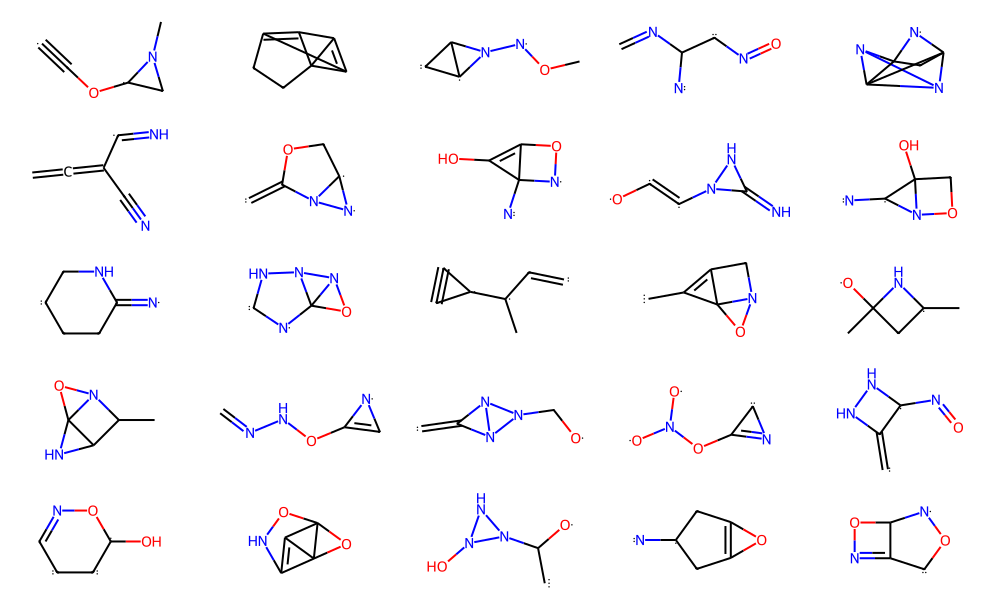

In [17]:
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120))


In [18]:
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)

[C]#CO[C]1CN1C
0.8348800614476204
C1CC23C4=C1C2=C43
0.5031357202678919
CO[N]N1[C]2[C]C21
0.7478358782827854
C=NC([N])[C]N=O
0.42926647141575813
C1C23[N]C14N1N2C134
0.47884721122682095
C=C=C([C]=N)C#N
0.5539120212197304
[C]=C1OC[C]2[N]N21
0.5062105767428875
[N]C12[N]OC1=C2O
0.9803892970085144
N=C1NN1[C]=[C][O]
0.37016103602945805
[N][C]1N2OCC12O
0.6294861994683743
[N]=C1CC[C]CN1
0.5672486424446106
[C]1[N]C23ON2N3N1
0.45450102537870407
[C]=C[C](C)[C]1C#C1
0.5808534137904644
[C]C1=C2CN3OC123
0.7515368461608887
C[C]1CC(C)([O])N1
0.6955188922584057
CC1C2NC23ON13
0.6216815486550331
C=NNOC1=C[N]1
0.5276191122829914
[C]=C1n2n(C[O])n21
0.42724381759762764
[O]N([O])OC1=N[C]1
0.5529897399246693
[C]=C1NN[C]1N=O
0.3551605585962534
O[C]1[C][C]C=NO1
0.6482914946973324
N1OC23OC24C1=C34
0.8078648969531059
[C]C([O])n1[nH]n1O
0.5346355475485325
[N][C]1CC2=C(C1)O2
1.083374410867691
[C]1O[N]C2ON=C12
0.6825151890516281


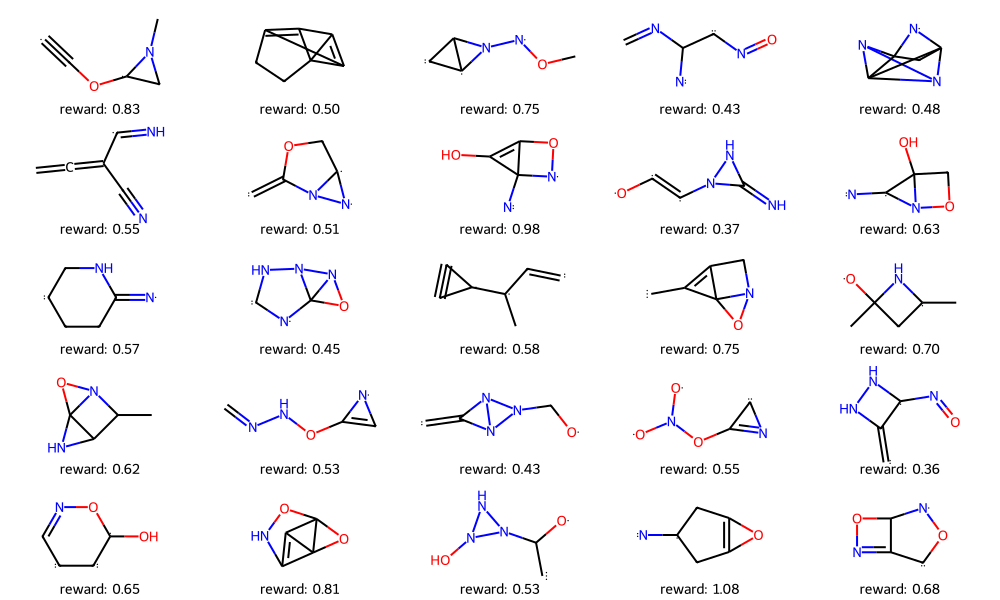

In [19]:
MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])